Showing the main code's outputs with jupyter notebook.

## Data Preparation

In [26]:
# Forecasting TOYOTA's Earnings

# importing external packages
import os
import datetime
import numpy as np
import pandas as pd
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# importing internal modules
import module_SARIMA
import module_accuracy

In [2]:
# run data_preprocessing.py file to generate data
os.system("python data_preprocessing.py")

# read cleaned data generated from data_preprocessing.py
ts = pd.read_csv("data/output/sample_ts.csv", index_col=0)

ts.head()

,決算期,決算月数,連結基準フラグ,決算種別フラグ,決算発表日,１株当たり利益［累計］,１株当たり利益［３ヵ月］
0,2007-06-01,3,2,21,2007-08-03,153.98,153.98
1,2007-09-01,6,2,22,2007-11-07,295.50,141.51
2,2007-12-01,9,2,23,2008-02-05,439.98,144.47
3,2008-03-01,12,2,10,2008-05-08,540.65,100.67
4,2008-06-01,3,2,21,2008-08-07,112.30,112.30


In [3]:
ts.describe()

,決算月数,連結基準フラグ,決算種別フラグ,１株当たり利益［累計］,１株当たり利益［３ヵ月］
count,52.000000,52.000000,52.000000,52.000000,52.000000
mean,7.500000,2.038462,19.000000,305.025192,111.228269
std,3.386826,0.194184,5.295207,243.287100,94.518150
min,3.000000,2.000000,10.000000,-139.130000,-244.180000
25%,5.250000,2.000000,18.250000,110.390000,37.612500
50%,7.500000,2.000000,21.500000,221.645000,135.645000
75%,9.750000,2.000000,22.250000,483.655000,178.367500
max,12.000000,3.000000,23.000000,842.000000,319.010000


In [4]:
# y
y = ts["１株当たり利益［３ヵ月］"]

# train (40) test (12) split
train_size = 40
y_train = y[:train_size]
y_test = y[train_size:]

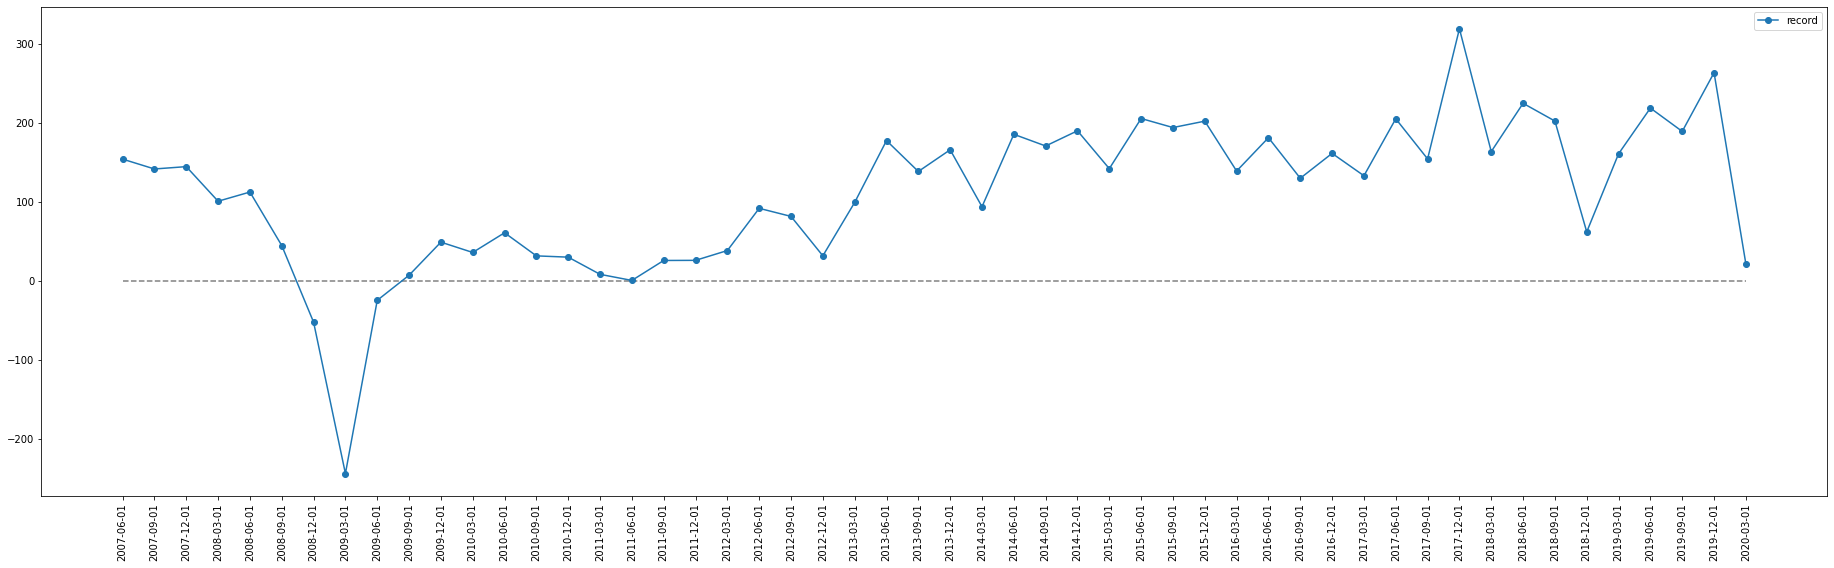

In [5]:
# viz
fig = plt.figure(figsize=(16*2, 9))
ax = fig.add_subplot(111)

ax.plot(ts["決算期"], [0] * len(ts["決算期"]), color="gray", linestyle="--")
ax.plot(ts["決算期"], y, marker="o", label="record")

ax.tick_params(axis="x", rotation=90)
ax.legend()
plt.show()

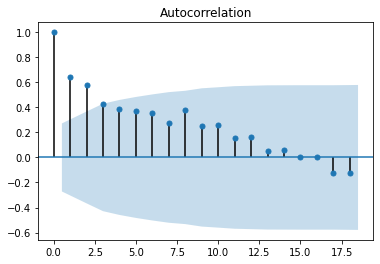

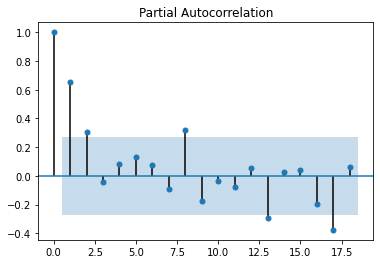

In [6]:
# Check stationality, seasonality, and trends.
# plot ACF
sm.tsa.graphics.plot_acf(y)
plt.show()
# plot PACF
sm.tsa.graphics.plot_pacf(y)
plt.show()

## Model Estimation

### Random walk

In [7]:
# random walk
y_hat_rw = y.shift(1)[-(len(y) - train_size):]
y_hat_rw

40    132.94
41    205.05
42    154.28
43    319.01
44    163.54
45    224.67
46    202.20
47     61.85
48    160.74
49    218.62
50    189.08
51    263.41
Name: １株当たり利益［３ヵ月］, dtype: float64

### SARIMA: Brown & Rozeff
$ (p, d, q) \times (P, D, Q)_S = (1, 0, 0) \times (0, 1, 1)_4 $

In [8]:
# SARIMA: Brown & Rozeff
y_hat_sarima_br = module_SARIMA.rolling_window(
    window = train_size,
    prim_train=y_train,
    test=y_test,
    order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 4),
    silent=True
)
y_hat_sarima_br

/home/wang_sihan/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/wang_sihan/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/wang_sihan/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/wang_sihan/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will 

40    184.089863
41    173.441442
42    188.928996
43    306.108404
44    216.770260
45    303.897548
46    230.042959
47    132.865969
48    162.881649
49    142.656535
50    166.045922
51    158.774337
dtype: float64

### SARIMA: Griffin
$ (p, d, q) \times (P, D, Q)_S = (0, 1, 1) \times (0, 1, 1)_4 $

In [9]:
# SARIMA: Griffin
y_hat_sarima_g = module_SARIMA.rolling_window(
    window = train_size,
    prim_train=y_train,
    test=y_test,
    order=(0, 1, 1),
    seasonal_order=(0, 1, 1, 4),
    silent=True
)
y_hat_sarima_g

/home/wang_sihan/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/wang_sihan/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/wang_sihan/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/wang_sihan/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will 

40    193.291562
41    175.949928
42    202.113328
43    378.934602
44    285.309464
45    326.715622
46    280.153068
47    187.407108
48    228.005606
49    220.562398
50    258.262331
51    283.176259
dtype: float64

### SARIMA: Foster
$ (p, d, q) \times (P, D, Q)_S = (1, 0, 0) \times (0, 1, 0)_4 $

In [10]:
# SARIMA: Foster
y_hat_sarima_f = module_SARIMA.rolling_window(
    window = train_size,
    prim_train=y_train,
    test=y_test,
    order=(1, 0, 0),
    seasonal_order=(0, 1, 0, 4),
    silent=True
)
y_hat_sarima_f

/home/wang_sihan/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/wang_sihan/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/wang_sihan/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/wang_sihan/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will 

40    177.166887
41    171.508266
42    210.794022
43    327.425389
44    221.066620
45    324.628146
46    233.137151
47     58.358015
48    224.039641
49     61.551715
50    218.468067
51    263.774272
dtype: float64

### Simple 3 layers Multi Layer Perceptron

In [38]:
# 3 Layers Feed Forward Neural Network
import module_nn

# y, x (lag 4)
y = ts["１株当たり利益［３ヵ月］"].drop([0, 1, 2, 3], axis=0)
y = y.reset_index(drop=True)

x = pd.DataFrame([
    ts["１株当たり利益［３ヵ月］"].shift(1),
    ts["１株当たり利益［３ヵ月］"].shift(2),
    ts["１株当たり利益［３ヵ月］"].shift(3),
    ts["１株当たり利益［３ヵ月］"].shift(4),
]).T.drop([0, 1, 2, 3], axis=0)
x = x.reset_index(drop=True)
x.columns = ["y_(t-1)", "y_(t-2)", "y_(t-3)", "y_(t-4)"]

y.head()

0    112.30
1     44.53
2    -52.49
3   -244.18
4    -24.82
Name: １株当たり利益［３ヵ月］, dtype: float64

In [39]:
x.head()

,y_(t-1),y_(t-2),y_(t-3),y_(t-4)
0,100.67,144.47,141.51,153.98
1,112.30,100.67,144.47,141.51
2,44.53,112.30,100.67,144.47
3,-52.49,44.53,112.30,100.67
4,-244.18,-52.49,44.53,112.30


In [40]:
dtype = torch.float
device = torch.device("cpu")

y = torch.tensor(y.values, dtype=dtype)
x = torch.tensor(x.values, dtype=dtype)

y.size(), x.size()

(torch.Size([48]), torch.Size([48, 4]))

In [44]:
# construct, instantiate FFNN
ffnn = module_nn.FFNN(input_features=4, hidden_units=100, output_units=1)
ffnn

FFNN(
  (hidden): Linear(in_features=4, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
)

## Predition Performance

In [14]:
# compare prediction performance with forecast accuracy indexes
accuracy = pd.DataFrame(
    [
        [
            module_accuracy.MAE(y_test, y_hat_rw),
            module_accuracy.MAE(y_test, y_hat_sarima_br),
            module_accuracy.MAE(y_test, y_hat_sarima_g),
            module_accuracy.MAE(y_test, y_hat_sarima_f),
        ],
        [
            module_accuracy.MAPE(y_test, y_hat_rw),
            module_accuracy.MAPE(y_test, y_hat_sarima_br),
            module_accuracy.MAPE(y_test, y_hat_sarima_g),
            module_accuracy.MAPE(y_test, y_hat_sarima_f),
        ],
        [
            module_accuracy.MSE(y_test, y_hat_rw),
            module_accuracy.MSE(y_test, y_hat_sarima_br),
            module_accuracy.MSE(y_test, y_hat_sarima_g),
            module_accuracy.MSE(y_test, y_hat_sarima_f),
        ],
        [
            module_accuracy.RMSE(y_test, y_hat_rw),
            module_accuracy.RMSE(y_test, y_hat_sarima_br),
            module_accuracy.RMSE(y_test, y_hat_sarima_g),
            module_accuracy.RMSE(y_test, y_hat_sarima_f),
        ],
        [
            module_accuracy.RMSPE(y_test, y_hat_rw),
            module_accuracy.RMSPE(y_test, y_hat_sarima_br),
            module_accuracy.RMSPE(y_test, y_hat_sarima_g),
            module_accuracy.RMSPE(y_test, y_hat_sarima_f),
        ]
    ],
    index=["MAE", "MAPE", "MSE", "RMSE", "RMSPE"],
    columns=["random walk", "SARIMA: BR", "SARIMA: G", "SARIMA: F"]
)
accuracy

,random walk,SARIMA: BR,SARIMA: G,SARIMA: F
MAE,97.488333,79.626291,91.984736,94.779795
MAPE,1.460989,1.024104,1.586353,1.493098
MSE,13433.926850,9265.566421,16495.247770,14300.965160
RMSE,115.904818,96.257812,128.433826,119.586643
RMSPE,3.384447,2.059803,3.733329,3.424572


## Visualize Preditctions

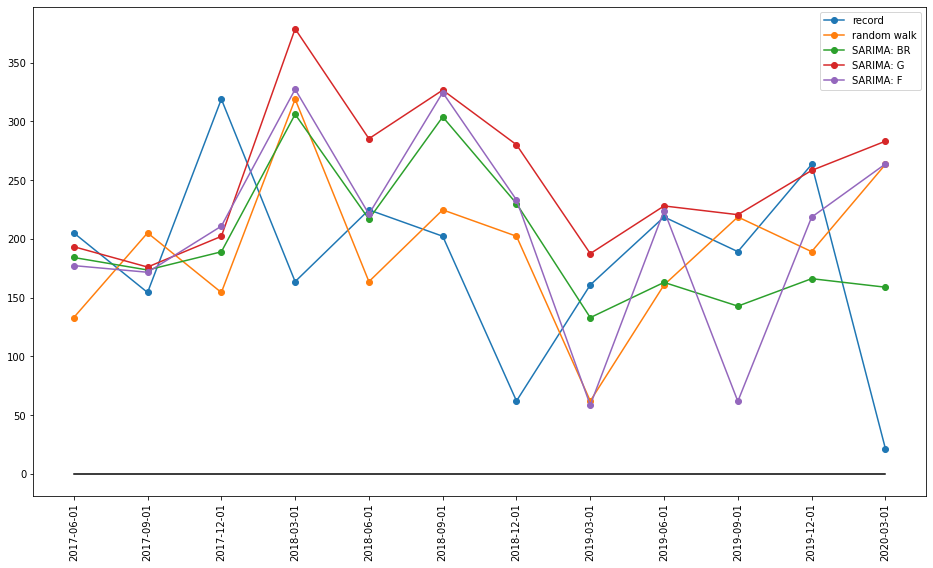

In [13]:
# plot each y_hat series
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.plot(ts["決算期"][train_size:], [0] * len(ts["決算期"][train_size:]), color="black")

ax.plot(ts["決算期"][train_size:], y_test, marker="o", label="record")
    

ax.plot(ts["決算期"][train_size:], y_hat_rw, marker="o", label="random walk")
ax.plot(ts["決算期"][train_size:], y_hat_sarima_br, marker="o", label="SARIMA: BR")
ax.plot(ts["決算期"][train_size:], y_hat_sarima_g, marker="o", label="SARIMA: G")
ax.plot(ts["決算期"][train_size:], y_hat_sarima_f, marker="o", label="SARIMA: F")

ax.tick_params(axis="x", rotation=90)
ax.legend()
plt.show()